In [1]:
print("Hello")

Hello


In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time
import copy

In [3]:
arr_example = np.random.normal(5,5,(2,50))

In [83]:
!pip install opencv-python

  Using cached https://files.pythonhosted.org/packages/30/46/821920986c7ce5bae5518c1d490e520a9ab4cef51e3e54e35094dadf0d68/opencv-python-4.4.0.46.tar.gz
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
anceled


## Functions

In [28]:
def shift(array):
    '''Takes np.array shaped as (3,N)
    the order is (x-value, y-value, time)
    Returns shifted np.array to the left upper corner
    '''
    min_x = min(array[0])
    min_y = min(array[1])
    low = list(map(lambda x: x - min_x, array[0]))
    high = list(map(lambda y: y - min_y, array[1]))
    return np.row_stack((low,high, array[2]))


def normalization(array, shape = (244,244)): #normalization to (0,resolution) in both axes
    max_arr = max(array[0].max(),abs(array[1].max()))
    low = list(map(lambda x: x * (shape[1] - 1) / max_arr, array[0]))
    high = list(map(lambda y: y * (shape[0] - 1) / max_arr, array[1]))
    return np.row_stack((low,high, array[2]))


def douglasPeucker(PointsArray, epsilon): #Упрощение кривой до ламаной
    #Находим точку с максимальным расстоянием от прямой между первой и последней точками набора
    dmax = 0
    index = 0
    p1 = PointsArray[:2,0]
    p2 = PointsArray[:2,-1]
    for i in range(2,PointsArray.shape[1] - 1):
        p3 = PointsArray[:2,i]
        d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)    #PerpendicularDistance
        if d > dmax:
            index = i
            dmax = d
    
    #Если максимальная дистанция больше, чем epsilon, то рекурсивно вызываем её на участках
    if dmax > epsilon:
        recResults1 = douglasPeucker(PointsArray[:,0:index], epsilon)
        recResults2 = douglasPeucker(PointsArray[:,index:-1], epsilon)
        ResultArray = np.row_stack((recResults1,recResults2))
    else:
        ResultArray = np.row_stack((PointsArray[:,1],PointsArray[:,-1]))
        
    return ResultArray


def one_direction_strokes(Points):
    #Caution!!  Returns LIST, not np.array
    
    if Points.shape[0] < 2:
        return Points
    
    ResultArray = []
    start_i = 0
    end_i = 1
    idk = 0
    while end_i < Points.shape[1] - 1:
        #negative scalar
        if sum((Points[:2,start_i+1]-Points[:2,start_i])*(Points[:2,end_i+1]-Points[:2,end_i])) < 0:
            ResultArray.append(Points[:,start_i:end_i])
            start_i = end_i
            end_i += 1
            idk = 1
        end_i += 1
        if end_i == Points.shape[1] - 1:
            ResultArray.append(Points[:,start_i:end_i+1])
        
    if idk == 0:
        return Points
    
    return ResultArray


def border_detection(FullMatrix): #takes matrix (with zeros and ones) and returns matrix of borders
    border = np.zeros(FullMatrix.shape)
    border[:,-1] = FullMatrix[:,-1]
    border[-1,:] = FullMatrix[-1,:]
    border[:,0] = FullMatrix[:,0]
    border[0,:] = FullMatrix[0,:]
    for i in range(1,FullMatrix.shape[0] - 1):
        for j in range(1, FullMatrix.shape[1] - 1):
            if (FullMatrix[i-1,j] == 0 or FullMatrix[i+1,j] == 0 \
            or FullMatrix[i,j-1] == 0 or FullMatrix[i,j+1] == 0) and FullMatrix[i,j] != 0:
                border[i,j] = 1         
    return border


def build_matrix(PointsList, shape = (244,244)):
    #build matrix from values shaped as (2+,N) to proceed pixel
    matrix = np.zeros(shape)
    points = []
    for k in range(len(PointsList[0])):
        points.append([int(PointsList[0][k]),int(PointsList[1][k])])
    
    for p in points:
        matrix[shape[0] - p[1] - 1,p[0]] = 1
    
    return matrix


def show_pixels(matrix):
    pixel_border = np.zeros( (matrix.shape[0],matrix.shape[1],3), dtype=np.uint8 )
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i,j]  != 1:
                pixel_border[i,j] = [255,255,255]
    plt.imshow(pixel_border, interpolation='nearest')
    plt.show()   

### DouglasPeucker illustration

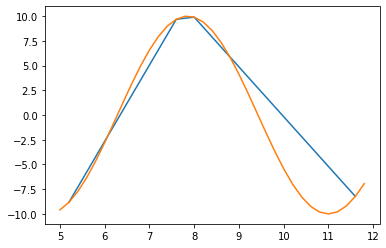

In [7]:
dougl = np.array(list(map(lambda x: [x+5,10*np.sin(x+5)], np.arange(35)/5)))
dougl = dougl.T
res_doug = douglasPeucker(dougl,3).T
plt.plot(res_doug[0], res_doug[1])
plt.plot(dougl[0],dougl[1])


### Shift to corner

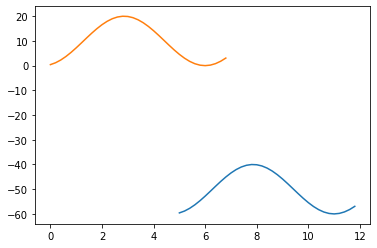

In [8]:
shift_check = np.array(list(map(lambda x: [x+5,10*(np.sin(x+5)-5)], np.arange(35)/5))).T
shifted = np.vstack((shift_check,np.arange(35)))
plt.plot(shifted[0],shifted[1])
plt.plot(shift(shifted)[0],shift(shifted)[1])

### "Normalization"

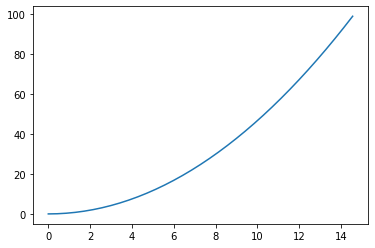

In [9]:
is_normal =  np.array(list(map(lambda x: [x,x**2], np.arange(35)/5))).T
is_normal = np.vstack((is_normal,np.arange(35)))
normalized = normalization(shift(is_normal), (100,100))
plt.plot(normalized[0],normalized[1])

### Borders

In [17]:
matrix = np.eye(10)
border = border_detection(matrix)
print(matrix)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Pixels from values in array

[[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11
  12 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19]
 [19 19 19 19 19 19 19 19 19 19 19 18 18 18 18 18 18 17 17 17 17 16 16 16
  15 15 14 14 13 13 12 12 11 10 10  9  8  6  5  3]]


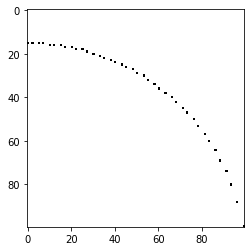

In [22]:
values = np.array(list(map(lambda x: [x, (390-x**2)**(1/2)], np.arange(0,20,0.5)))).T
print(values.astype(int))
values = np.vstack((values,np.arange(40)))
show_pixels(build_matrix(normalization(shift(values), shape = (100,100)), shape = (100,100)))

In [86]:
finger.shape

(225, 225)

In [62]:
img = image_to_numpy.load_image_file("finger.png", mode="L")

In [85]:
finger = image_to_numpy.load_image_file("finger2.jpg", mode="L")

In [78]:
brain = image_to_numpy.load_image_file("brain.jpg", mode="L")

In [73]:
def podgonka(image_1):
    image = copy.copy(image_1)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j] < 200:
                image[i,j] = 1
            else:
                image[i,j] = 0
    return image

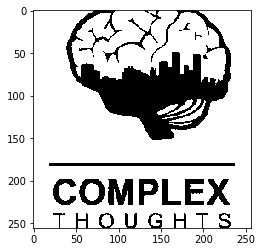

In [81]:
show_pixels(podgonka(brain))

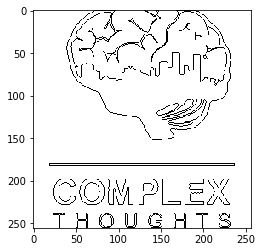

In [79]:
show_pixels(border_detection(podgonka(brain)))

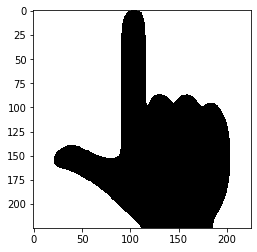

In [84]:
show_pixels(podgonka(finger))

In [ ]:
def trend_detection(FullMatrix, eps):
    trend = []
    i = 0
    while i < FullMatrix.shape[0] - 1:
        j = i+1
        while j < FullMatrix.shape[0] - 1:
            if FullMatrix[j,2] - FullMatrix[i,2] > eps:
                trend.append(get_centre(FullMatrix[i:j+1]))
                i = j
            j += 1
            
            
            

In [70]:
!pip install update torch
!pip install -q geffnet

In [87]:
!pip uninstall torch -y
!pip install torch==1.6.0 torchvision==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached torch-1.6.0-cp37-none-macosx_10_9_x86_64.whl (97.4 MB)
  Using cached torchvision-0.7.0-cp37-cp37m-macosx_10_9_x86_64.whl (387 kB)
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.1
    Uninstalling torchvision-0.8.1:
      Successfully uninstalled torchvision-0.8.1


In [82]:
import os
import cv2

import geffnet
import torch

In [83]:
cwd = os.getcwd()
os.chdir("/Users/vamdemon/Desktop/KPI/STP/Backend/") 
os.listdir()

['.DS_Store',
 'test_border.jpg',
 'test_border.png',
 'backend',
 'test.png',
 '.idea']

In [88]:
from backend.backend.settings import MODEL as model

RuntimeError: version_ <= kMaxSupportedFileFormatVersion INTERNAL ASSERT FAILED at ../caffe2/serialize/inline_container.cc:132, please report a bug to PyTorch. Attempted to read a PyTorch file with version 3, but the maximum supported version for reading is 2. Your PyTorch installation may be too old. (init at ../caffe2/serialize/inline_container.cc:132)
frame #0: c10::Error::Error(c10::SourceLocation, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&) + 135 (0x1373f0787 in libc10.dylib)
frame #1: caffe2::serialize::PyTorchStreamReader::init() + 2350 (0x12b7cf14e in libtorch.dylib)
frame #2: caffe2::serialize::PyTorchStreamReader::PyTorchStreamReader(std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&) + 143 (0x12b7ce79f in libtorch.dylib)
frame #3: void pybind11::cpp_function::initialize<void pybind11::detail::initimpl::constructor<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >::execute<pybind11::class_<caffe2::serialize::PyTorchStreamReader>, 0>(pybind11::class_<caffe2::serialize::PyTorchStreamReader>&)::'lambda'(pybind11::detail::value_and_holder&, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >), void, pybind11::detail::value_and_holder&, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, pybind11::name, pybind11::is_method, pybind11::sibling, pybind11::detail::is_new_style_constructor>(pybind11::class_<caffe2::serialize::PyTorchStreamReader>&&,  (*)(0...), void pybind11::detail::initimpl::constructor<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >::execute<pybind11::class_<caffe2::serialize::PyTorchStreamReader>, 0>(pybind11::class_<caffe2::serialize::PyTorchStreamReader>&)::'lambda'(pybind11::detail::value_and_holder&, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >) const&...)::'lambda'(pybind11::detail::function_call&)::operator()(pybind11::detail::function_call&) const + 147 (0x1297acc13 in libtorch_python.dylib)
frame #4: pybind11::cpp_function::dispatcher(_object*, _object*, _object*) + 3372 (0x1291a69fc in libtorch_python.dylib)
<omitting python frames>


In [63]:
image = cv2.imread("test.png", cv2.IMREAD_UNCHANGED)
image_alpha = image[:, :, 3]
#image_alpha = border_detection(image_alpha)
image_preprocessed = cv2.resize(image_alpha, (64, 64))

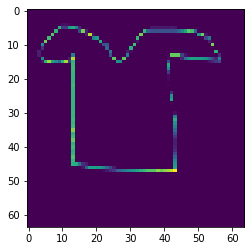

In [64]:
plt.imshow(image_preprocessed)

(224, 224)